# Real-time video segmentation

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, ignite, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Imports

In [2]:
import cv2
from glob import glob
import os
import tempfile
import random
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
 
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm, trange

import monai
from monai.data import (
    Dataset,
    CacheDataset,
    PersistentDataset,
    DataLoader,
)
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks import eval_mode
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    AddChanneld,
    AsChannelFirstd,
    AsDiscrete,
    Compose,
    DivisiblePadd,
    LoadImaged,
    ScaleIntensityd,
    ToTensord,
    Rotate90d,
    MapTransform,
)
from monai.utils import set_determinism
from monai.data import decollate_batch

monai.config.print_config()

# Set deterministic training for reproducibility
set_determinism(seed=0)

MONAI version: 0.6.0+24.g325775bc
Numpy version: 1.20.3
Pytorch version: 1.9.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 325775bceb1bfd5e45e971823a3fe764dbdb3f5c

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 8.3.1
Tensorboard version: 2.5.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.61.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Transforms

In [3]:
hook, grasper = 31, 32

class RGBToMask(MapTransform):
    def __init__(self, keys, vals, allow_missing_keys=False):
        super().__init__(keys, allow_missing_keys)
        self.vals = vals

    def __call__(self, data):
        d = dict(data)
        for key in self.key_iterator(d):
            d[key] = d[key][0][None]
            d[key] = np.in1d(d[key], self.vals).reshape(d[key].shape)
            d[key] = d[key].astype(np.float32)
        return d
        
        
keys = ["image", "label"]
transforms = Compose([
    LoadImaged(keys),
    AsChannelFirstd(keys),
    Rotate90d(keys),
    RGBToMask("label", (hook, grasper)),
    DivisiblePadd(keys, 16),
    ScaleIntensityd(keys),
    ToTensord(keys),
])

## Dataset and dataloader

In [4]:
root_dir = os.environ.get("MONAI_DATA_DIRECTORY")
if root_dir is not None:
    cache_dir = os.path.join(root_dir, "CholecSeg8K_PersistentDataset")
else:
    cache_dir = tempfile.mkdtemp()

def get_ds_and_dl(data, transforms, dataset="persistentdataset"):
    if dataset.lower() == "cachedataset":
        ds = CacheDataset(data, transforms, num_workers=10)
    elif dataset.lower() == "persistentdataset":
        ds = PersistentDataset(data, transforms, cache_dir)
    else:
        ds = Dataset(data, transforms)
    dl = DataLoader(ds, batch_size=10, num_workers=10, drop_last=True)
    return ds, dl

## Data

download the data from https://www.kaggle.com/newslab/cholecseg8k. Set the folder below accordingly.

In [5]:
data_dir = "/home/rich/Documents/Data/RealTimeSeg/CholecSeg8k"
if not os.path.isdir(data_dir):
    raise RuntimeError("data not found")

In [6]:
images = sorted(glob(os.path.join(data_dir , "*", "*", "*[!mask].png")))
labels = sorted(glob(os.path.join(data_dir , "*", "*", "*_watershed_mask.png")))
data_dict = [{"image": i, "label": l} for i, l in zip(images, labels)]
print("Total num frames", len(data_dict))

# discard data where label==0 throughout
all_ds, all_dl = get_ds_and_dl(data_dict, transforms)
non_zero_data_dict = []
for i in tqdm(all_dl, desc="finding non-zero labels"):
    for j in decollate_batch(i):
        if j["label"].max() > 0.5:
            non_zero_data_dict.append(
                {
                    k: j[k + "_meta_dict"]["filename_or_obj"] for k in keys
                }
            )
print("Total num non-zero frames", len(non_zero_data_dict))

train_file_dict, val_file_dict = train_test_split(
    non_zero_data_dict, test_size=int(0.2 * len(non_zero_data_dict))
)

print("Num training image/label pairs:", len(train_file_dict))
print("Num validation image/label pairs:", len(val_file_dict))

train_ds, train_dl = get_ds_and_dl(train_file_dict, transforms)
val_ds, val_dl = get_ds_and_dl(val_file_dict, transforms)

Total num frames 8080


finding non-zero labels: 100%|██████████| 808/808 [00:18<00:00, 43.59it/s]

Total num non-zero frames 6438
Num training image/label pairs: 5151
Num validation image/label pairs: 1287


## Show selection

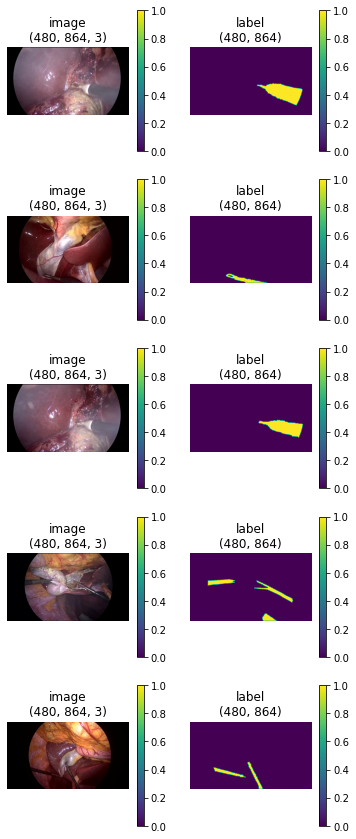

In [7]:
%matplotlib inline
def imshows(ims, colorbar=True):
    nrow = len(ims)
    ncol = len(ims[0])
    fig, axes = plt.subplots(nrow, ncol, figsize=(
        ncol * 3, nrow * 3), facecolor='white')
    for i, im_dict in enumerate(ims):
        for j, (title, im) in enumerate(im_dict.items()):
            if isinstance(im, torch.Tensor):
                im = im.detach().cpu().numpy()
            # If RGB, put to end. Else, average across channel dim
            if im.ndim > 2:
                im = np.moveaxis(im, 0, -1) if im.shape[0] == 3 else np.mean(im, axis=0)

            ax = axes[j] if len(ims) == 1 else axes[i, j]
            ax.set_title(f"{title}\n{im.shape}")
            im_show = ax.imshow(im)
            ax.axis("off")
            if colorbar:
                fig.colorbar(im_show, ax=ax)

to_imshow = []
for i in np.random.choice(train_file_dict, size=5, replace=False):
    j = transforms(i)
    to_imshow.append({k: j[k] for k in keys})
imshows(to_imshow)

In [8]:
# Create network, loss fn., etc.
post_trans = Compose([
    Activations(sigmoid=True),
    AsDiscrete(threshold_values=True),
])
in_channels = train_ds[0]["image"].shape[0]
print("in channels:", in_channels)
# create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(
    dimensions=2,
    in_channels=in_channels,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
loss_function = DiceLoss(sigmoid=True)
dice_metric = DiceMetric(reduction="mean")

in channels: 3


In [9]:
def infer_seg(images, model):
    return post_trans(model(images))

In [10]:
best_model_path = "best_model_cholecseg.pth"
always_train = False
do_training = always_train or not os.path.isfile(best_model_path)
if do_training:

    # start a typical PyTorch training
    max_epochs = 25
    val_interval = 1
    best_metric = -1
    best_metric_epoch = -1
    writer = SummaryWriter()

    for epoch in trange(max_epochs):
        model.train()
        epoch_loss = 0

        for batch_data in train_dl:
            inputs = batch_data["image"].to(device)
            labels = batch_data["label"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        epoch_loss /= len(train_dl)
        writer.add_scalar("Loss/training", epoch_loss, epoch)
        writer.add_images("Train/image", inputs, epoch)
        writer.add_images("Train/label", labels, epoch)
        writer.add_images("Train/infer", post_trans(outputs), epoch)

        if (epoch + 1) % val_interval == 0:
            with eval_mode(model):
                metric_list = []
                for val_data in val_dl:
                    val_images, val_labels = val_data["image"].to(
                        device), val_data["label"].to(device)
                    val_outputs = infer_seg(val_images, model)
                    value = dice_metric(y_pred=val_outputs, y=val_labels)
                    metric_list += value[~value.isnan()].tolist()
                metric = np.mean(metric_list)
                writer.add_scalar("Loss/validation", metric, epoch)
                writer.add_images("Val/image", val_images, epoch)
                writer.add_images("Val/label", val_labels, epoch)
                writer.add_images("Val/infer", val_outputs, epoch)

                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), best_model_path)

    print(
        f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

In [11]:
model.load_state_dict(torch.load(best_model_path, map_location=device))
_ = model.eval()
# save as jit model
jit_fname = best_model_path[:-4] + "_jit.pt"
torch.jit.save(torch.jit.script(model.cpu()), jit_fname)
_ = model.to(device)

# Check segmentations

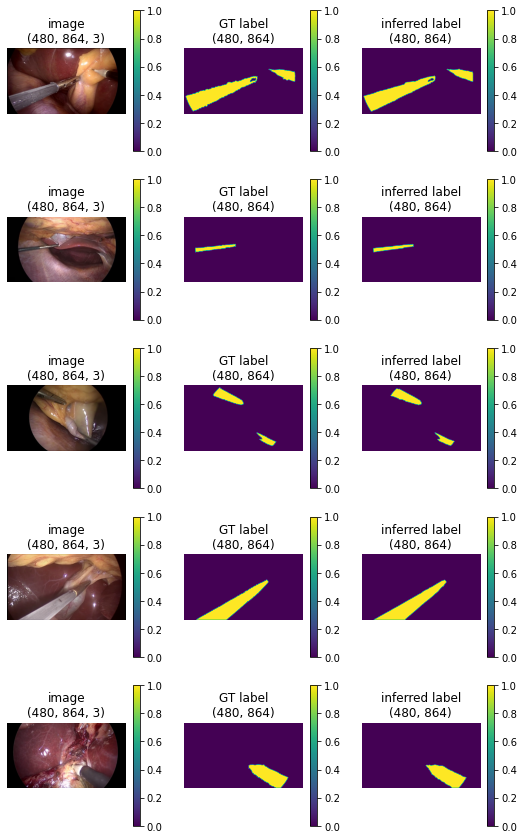

In [12]:
%matplotlib inline
to_imshow = []
for data in np.random.choice(val_ds, size=5, replace=False):
    im, label = data["image"], data["label"]
    im_gpu = im[None].to(device)
    inferred = infer_seg(im_gpu, model)[0]
    to_imshow.append({
        "image": im,
        "GT label": label,
        "inferred label": inferred,
    })
imshows(to_imshow)

## Time the inference

In [13]:
d = transforms(val_file_dict[0])
im_gpu = d["image"][None].to(device)

%timeit infer_seg(im_gpu, model)

8.66 ms ± 136 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Generating video

In [22]:
def create_video(in_files, output_file, fps, skip_if_present=False):
    codec = "mp4v" if output_file[-3:] == "mp4" else "MP42"
    fourcc = cv2.VideoWriter_fourcc(*codec)

    if skip_if_present and os.path.isfile(output_file):
        print(f"video alread present f({len(in_files)} frames), skipping: {output_file}.")
        return
    print(f"{len(in_files)} frames @ {fps} fps: {output_file}...")

    for idx, image in enumerate(in_files):
        frame = cv2.imread(image)
        if idx == 0:
            width_height = frame.shape[:-1][::-1]
            video = cv2.VideoWriter(output_file, fourcc, fps, width_height)
        a = video.write(frame)
    video.release()
    if not os.path.isfile(output_file):
        raise RuntimeError("video not created:", output_file)

def create_videos(folder, fps):
    image_vid_fnames, label_vid_fnames = [], []
    for vid_dir in sorted(glob(os.path.join(folder, "*"))):
        
        images = sorted(glob(os.path.join(vid_dir, "*", "*[!mask].png")))
        labels = sorted(glob(os.path.join(vid_dir, "*", "*_watershed_mask.png")))

        image_vid_fnames.append(os.path.join(vid_dir, f"endo.mp4"))
        label_vid_fnames.append(os.path.join(vid_dir, f"endo_watershed_mask.mp4"))

        create_video(images, image_vid_fnames[-1], fps, skip_if_present=True)
        create_video(labels, label_vid_fnames[-1], fps, skip_if_present=True)
    return image_vid_fnames, label_vid_fnames

# CholecSeg8K is 25Hz:
# https://www.kaggle.com/newslab/cholecseg8k
fps = 25
train_image_vids, train_label_vids = create_videos(data_dir, fps)

video alread present f(1280 frames), skipping: /home/rich/Documents/Data/RealTimeSeg/CholecSeg8k/video01/endo.mp4.
video alread present f(1280 frames), skipping: /home/rich/Documents/Data/RealTimeSeg/CholecSeg8k/video01/endo_watershed_mask.mp4.
video alread present f(240 frames), skipping: /home/rich/Documents/Data/RealTimeSeg/CholecSeg8k/video09/endo.mp4.
video alread present f(240 frames), skipping: /home/rich/Documents/Data/RealTimeSeg/CholecSeg8k/video09/endo_watershed_mask.mp4.
video alread present f(640 frames), skipping: /home/rich/Documents/Data/RealTimeSeg/CholecSeg8k/video12/endo.mp4.
video alread present f(640 frames), skipping: /home/rich/Documents/Data/RealTimeSeg/CholecSeg8k/video12/endo_watershed_mask.mp4.
video alread present f(320 frames), skipping: /home/rich/Documents/Data/RealTimeSeg/CholecSeg8k/video17/endo.mp4.
video alread present f(320 frames), skipping: /home/rich/Documents/Data/RealTimeSeg/CholecSeg8k/video17/endo_watershed_mask.mp4.
video alread present f(160

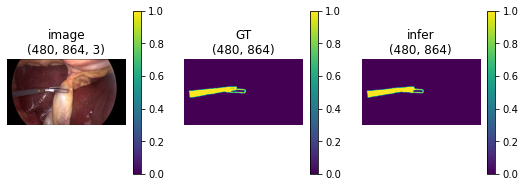

In [32]:
frame = 277
fnames = {
    "image": f"/home/rich/Documents/Data/RealTimeSeg/CholecSeg8k/video01/video01_00240/frame_{frame}_endo.png",
    "label": f"/home/rich/Documents/Data/RealTimeSeg/CholecSeg8k/video01/video01_00240/frame_{frame}_endo_watershed_mask.png",
}
inputs = transforms(fnames)
image, label = inputs["image"], inputs["label"]
inferred = post_trans(model(image[None].cuda()))[0]
imshows([
    {
        "image": image,
        "GT": label,
        "infer": inferred,
    }
])